## Creating forecast for HydroBoost

## Imports and Helper Functions

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from datetime import timedelta

from prophet import Prophet

import plotly
import plotly.express as px


def initialize_empty_dataframe_for_forecast(df):
    """
    Initialize an empty dataframe for the 7-day forecast. Index of hours and columns are dates.
    """
    # Need values for the dataframe index(forecast hours) and columns (dates)
    dates = list(set(df.index.date))
    dates = pd.to_datetime(dates)
    dates = dates.sort_values()

    hours = [i for i in range(0, 7*24)]

    x = pd.DataFrame(index=dates, columns=hours)

    return x

## Import the price data and forecast data from ALEAF input spreadsheets

In [2]:
def read_ALEAF_input_spreadsheet(ALEAF_input_spreadsheet_path):
    """
    Read in the time series price and forecast data from the
    ALEAF input spread sheet
    """

    # Data from the energy price, this is required data
    df_price = pd.read_excel(ALEAF_input_spreadsheet_path, 
                       sheet_name="Hourly Time Series", 
                       skiprows=[0], 
                       index_col="Date-Time", 
                       usecols=["Date-Time", 
                                "Energy-DA", 
                                "Regulation Up", 
                                "Regulation Down", 
                                "Spinning Reserve",
                                ], 
                       parse_dates=False,
                       )
    
    # Data from the forecasting, not required
    df_forecast = pd.read_excel(ALEAF_input_spreadsheet_path,
                                sheet_name="Forecasting Data",
                                skiprows=[0],
                                index_col="Date-Time",
                                parse_dates=False,
                                )
    
    # Set them to datetime series 
    df_price.index = pd.to_datetime(df_price.index)
    df_forecast.index = pd.to_datetime(df_forecast.index)
    
    # Make sure the dates are sorted
    df_price = df_price.sort_index()
    df_forecast = df_forecast.sort_index()

    # Make sure they are hour timesteps
    df_price = df_price.resample('h').mean()
    df_forecast = df_forecast.resample('h').mean()

    # See if forecast data was provided
    if len(df_forecast.columns) > 0:
        forecast_data_included = True
    else:
        forecast_data_included = False
        
    # Join the price and forecast data
    df = df_price.join(df_forecast)

    df = df.bfill()

    return df, forecast_data_included

df_ALEAF, forecast_data_included = read_ALEAF_input_spreadsheet("ALEAF_Input_Spreadsheet.xlsx")
df_ALEAF

,Energy-DA,Regulation Up,Regulation Down,Spinning Reserve,DA-Demand,DA-Temperature
Date-Time,,,,,,
2025-01-01 00:00:00,32.22,11.284167,0.237500,0.05,10845.4,46.0
2025-01-01 01:00:00,32.12,11.383333,0.300000,0.30,10593.7,46.0
2025-01-01 02:00:00,30.76,12.375000,0.112500,0.05,10207.3,45.0
2025-01-01 03:00:00,29.60,11.763333,0.258333,0.05,10026.4,45.0
2025-01-01 04:00:00,30.78,12.405000,0.112500,0.05,10283.0,45.0
...,...,...,...,...,...,...
2025-12-31 19:00:00,38.88,21.605833,0.075000,0.01,11992.9,51.0
2025-12-31 20:00:00,38.68,10.656667,0.230000,0.01,11444.8,50.0
2025-12-31 21:00:00,38.65,12.466667,0.083333,0.05,10394.4,50.0


## Perfect Foresight Model

In [3]:
def create_perfect_foresight_forecast(df_ALEAF, save_excel_file=True):
    """
    Creates an Excel sheet with 7-day forecast using perfect foresight
    Input: dataframe constructed using read_ALEAF_input_spreadsheet function.
    Note: Writing to Excel file is slow.
    """

    def get_forecast(forecast, price_column):
        """
        Helper function to run each price: LMP, Reg up/down, Spinning reserve
        """

        for date in forecast.index:

            # Start with an empty array
            x = np.empty(7*24)

            # Find what the actual values are and add them to empty array
            temp = df_ALEAF.loc[date:date + timedelta(days=7) - timedelta(hours=1), price_column].to_numpy()  

            # The last week doesn't have a week of future data, so we will duplicate the last day
            if len(temp) < 168:
                # Get the last day of values and duplicate it
                vals = temp[-24:]
                vals = np.tile(vals, 5)
    
                # Append them and take the number of values needed
                temp = np.append(temp, vals)
                temp = temp[0: 168]

            x[:len(temp)] = temp      
            
            forecast.loc[date] = x

        return forecast
    
    # Initialize an empty dataframe for the forecast
    empty_forecast = initialize_empty_dataframe_for_forecast(df_ALEAF)

    # Get all the forecast using helper function 
    LMP_forecast = get_forecast(empty_forecast.copy(), "Energy-DA")
    Reg_up_forecast = get_forecast(empty_forecast.copy(), "Regulation Up")
    Reg_down_forecast = get_forecast(empty_forecast.copy(), "Regulation Down")
    Spin_forecast = get_forecast(empty_forecast.copy(), "Spinning Reserve")

    # Lets drop the timestamp from the column names M-d-Y H:mm:ss --> M-d-Y 
    dates_to_string = LMP_forecast.index.astype(str)

    # Want the index as strings not datetimes
    LMP_forecast.index = dates_to_string
    Reg_up_forecast.index = dates_to_string
    Reg_down_forecast.index = dates_to_string
    Spin_forecast.index = dates_to_string
    
    # Saving the results
    if save_excel_file:

        # Make sure there is a folder to write the results to 
        if os.path.exists(os.path.join(os.getcwd(), "Forecast_Generated")) == False:
            os.mkdir("Forecast_Generated")
            print("Created Forecast_Generated directory")

        # Single Excel file with multiple sheets
        with pd.ExcelWriter("Forecast_Generated/Perfect_Foresight.xlsx") as writer:
            LMP_forecast.T.to_excel(writer, sheet_name="LMP")
            Reg_up_forecast.T.to_excel(writer, sheet_name="Reg Up")
            Reg_down_forecast.T.to_excel(writer, sheet_name="Reg Down")
            Spin_forecast.T.to_excel(writer, sheet_name="Spin")

    # Return the results as a dict
    return {"LMP": LMP_forecast, 
            "Regulation Up": Reg_up_forecast, 
            "Regulation Down": Reg_down_forecast,
            "Spin": Spin_forecast}

perfect_foresight_forecast = create_perfect_foresight_forecast(df_ALEAF, False)

perfect_foresight_forecast["LMP"].head(3)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
2025-01-01,32.22,32.12,30.76,29.6,30.78,30.72,30.62,30.64,32.53,33.21,...,152.05,148.48,159.05,184.72,173.06,171.19,162.15,156.5,156.14,141.5
2025-01-02,31.58,27.06,25.76,25.0,16.33,23.38,27.11,29.24,32.39,36.09,...,124.18,133.96,175.0,208.41,205.83,192.68,183.38,152.89,152.67,145.0
2025-01-03,38.66,38.0,33.9,35.8,39.78,40.72,55.66,55.0,52.99,51.47,...,135.83,143.37,171.0,204.51,180.93,150.5,134.42,126.43,119.63,82.02


## Mean persistence model using n-days previous Hourly Means

In [4]:
def create_mean_persistence_forecast(perfect_foresight_forecast, n_days=14, save_excel_file=True):
    """
    Creates an Excel sheet with 7-day forecast using mean persistence
    Input: resulting dataframe form perfect foresight model, number of days to use for mean persistance 
    Note: Writing to Excel file is slow.
    """

    def get_forecast(forecast_df):
        """
        Helper function to run each price: LMP, Reg up/down, Spinning reserve
        """
        
        for idx, date in enumerate(forecast_df.index):
            
            # Use the previous days mean to forecast days 2-7, with day-ahead being correct values
            if idx == 0:
                hour_means = forecast_df.iloc[0, 0:24].to_numpy()
            elif idx < n_days:
                hour_means = forecast_df.iloc[0:idx, 0:24].mean().to_numpy()
            else:
                hour_means = forecast_df.iloc[idx-n_days:idx, 0:24].mean().to_numpy()

            hour_means = np.tile(hour_means, 6)

            forecast_df.iloc[idx, 24:] = hour_means

        return forecast_df
    
    # Get mean persistance for LMP, reg up/down and spinning reserve
    LMP_forecast = get_forecast(perfect_foresight_forecast["LMP"].copy())
    Reg_up_forecast = get_forecast(perfect_foresight_forecast["Regulation Up"].copy())
    Reg_down_forecast = get_forecast(perfect_foresight_forecast["Regulation Down"].copy())
    Spin_forecast = get_forecast(perfect_foresight_forecast["Spin"].copy())

    # Lets drop the timestamp from the column names M-d-Y H:mm:ss --> M-d-Y 
    dates_to_string = LMP_forecast.index.astype(str)

    LMP_forecast.index = dates_to_string
    Reg_up_forecast.index = dates_to_string
    Reg_down_forecast.index = dates_to_string
    Spin_forecast.index = dates_to_string
    
    # Saving the Excel file
    if save_excel_file:

        # Make sure there is a folder to write the results to 
        if os.path.exists(os.path.join(os.getcwd(), "Forecast_Generated")) == False:
            os.mkdir("Forecast_Generated")
            print("Created Forecast_Generated directory")

        # Wright to single excel file with multiple sheets
        with pd.ExcelWriter("Forecast_Generated/Mean_Persistence_Forecast.xlsx") as writer:
            LMP_forecast.T.to_excel(writer, sheet_name="LMP")
            Reg_up_forecast.T.to_excel(writer, sheet_name="Reg Up")
            Reg_down_forecast.T.to_excel(writer, sheet_name="Reg Down")
            Spin_forecast.T.to_excel(writer, sheet_name="Spin")

    # Return the results as a dict
    return {"LMP": LMP_forecast, 
            "Regulation Up": Reg_up_forecast, 
            "Regulation Down": Reg_down_forecast,
            "Spin": Spin_forecast,}


mean_forecast = create_mean_persistence_forecast(perfect_foresight_forecast, 7, False)
mean_forecast["LMP"].head(3)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
2025-01-01,32.22,32.12,30.76,29.6,30.78,30.72,30.62,30.64,32.53,33.21,...,32.97,33.92,37.47,50.44,37.48,34.86,33.01,33.27,29.73,29.39
2025-01-02,31.58,27.06,25.76,25.0,16.33,23.38,27.11,29.24,32.39,36.09,...,32.97,33.92,37.47,50.44,37.48,34.86,33.01,33.27,29.73,29.39
2025-01-03,38.66,38.0,33.9,35.8,39.78,40.72,55.66,55.0,52.99,51.47,...,37.105,38.61,46.735,56.105,50.205,47.63,42.66,40.035,34.73,32.84


## Prophet Model no Regressors
Single model from year data

In [25]:
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

def create_prophet_model_no_regressors(df_ALEAF, perfect_foresight_forecast, save_excel_file=True):

    df_prophet = df_ALEAF[["Energy-DA"]].copy()
    df_prophet = df_prophet.reset_index()
    df_prophet = df_prophet.rename(columns={"Date-Time": "ds", "Energy-DA": "y"})
    m = Prophet(changepoint_prior_scale=1, changepoint_range=1)
    m.fit(df_prophet)

    forecast = perfect_foresight_forecast["LMP"].copy()

    results = m.predict(m.make_future_dataframe(periods=24*8))["yhat"].to_numpy()[25:]

    for i, date in enumerate(forecast.index):
        temp = results[(i)*24:(i+6)*24]
        forecast.iloc[i, 24:] = temp

    # Lets drop the timestamp from the column names M-d-Y H:mm:ss --> M-d-Y 
    forecast.index = forecast.index.astype(str)

    # Saving the Excel file
    if save_excel_file:

        # Make sure there is a folder to write the results to 
        if os.path.exists(os.path.join(os.getcwd(), "Forecast_Generated")) == False:
            os.mkdir("Forecast_Generated")
            print("Created Forecast_Generated directory")

        forecast.to_excel("Forecast_Generated/Prophet_Forecast_no_Regressors.xlsx")

    return forecast

prophet_forecast_no_regressors = create_prophet_model_no_regressors(df_ALEAF, perfect_foresight_forecast, save_excel_file=True)
prophet_forecast_no_regressors.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
2025-01-01,32.22,32.12,30.76,29.6,30.78,30.72,30.62,30.64,32.53,33.21,...,119.739793,130.114506,136.36065,134.448107,125.138285,113.63151,105.531841,102.642089,102.303917,100.701501
2025-01-02,31.58,27.06,25.76,25.0,16.33,23.38,27.11,29.24,32.39,36.09,...,123.421049,133.735713,139.974767,138.10935,128.901612,117.552102,109.664578,107.041026,107.021765,105.789125
2025-01-03,38.66,38.0,33.9,35.8,39.78,40.72,55.66,55.0,52.99,51.47,...,137.67768,148.628457,155.477763,154.192127,145.529374,134.686047,127.262254,125.056721,125.406909,124.492728
2025-01-04,96.73,83.42,81.56,83.93,92.1,97.57,99.75,123.58,112.9,99.82,...,154.761275,165.242098,171.592355,169.782282,160.573455,149.166176,141.164274,138.370128,138.12475,136.611462
2025-01-05,134.02,113.05,101.37,107.19,111.13,109.68,111.28,134.39,136.53,138.75,...,159.128828,169.234985,175.229732,173.082718,163.55483,151.845605,143.558059,140.493737,139.992822,138.237833


## Prophet with Regressors
If they are provided

In [39]:
def create_prophet_model_with_regressors(df_ALEAF, perfect_foresight_forecast, save_excel_file=True):

    # Get the dataframe needed
    df_prophet = df_ALEAF.copy()
    df_prophet = df_prophet.drop(columns=["Regulation Up", "Regulation Down", "Spinning Reserve"])
    df_prophet = df_prophet.reset_index()
    df_prophet = df_prophet.rename(columns={"Date-Time": "ds", "Energy-DA": "y"})

    # Make the model
    m = Prophet(changepoint_prior_scale=1, changepoint_range=1)

    # Find and add the regressors to the model
    regressors = df_prophet.columns.to_list()[2:]

    for regressor in regressors:
        m.add_regressor(regressor)

    # Train the model
    m.fit(df_prophet)

    # Need to update our dataframe, need to extend dataframe at the end of the year 6 days 
    last_day = df_prophet.iloc[-24:, :]

    for i in range(7):
        temp = last_day.copy()
        temp['ds'] = temp["ds"] + timedelta(days=(i+1))
        df_prophet = pd.concat([df_prophet, temp])

    predictions = m.predict(df_prophet)["yhat"].to_numpy()[25:]

    forecast = perfect_foresight_forecast["LMP"].copy()

    for i, date in enumerate(forecast.index):
        temp = predictions[i*24:(i+6)*24]
        forecast.iloc[i, 24:] = temp


    # Saving the Excel file
    if save_excel_file:

        # Make sure there is a folder to write the results to 
        if os.path.exists(os.path.join(os.getcwd(), "Forecast_Generated")) == False:
            os.mkdir("Forecast_Generated")
            print("Created Forecast_Generated directory")

        forecast.to_excel("Forecast_Generated/Prophet_Forecast_with_Regressors.xlsx")

    return forecast

prophet_forecast_with_regressors = create_prophet_model_with_regressors(df_ALEAF, perfect_foresight_forecast, True)
prophet_forecast_with_regressors.head(3)

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
2025-01-01,32.22,32.12,30.76,29.6,30.78,30.72,30.62,30.64,32.53,33.21,...,115.74073,126.492421,136.584292,132.018753,125.988208,122.924555,120.126626,116.265497,110.313552,110.108668
2025-01-02,31.58,27.06,25.76,25.0,16.33,23.38,27.11,29.24,32.39,36.09,...,111.944408,134.22002,147.856987,142.614178,133.393065,127.159142,124.806686,120.879521,115.5118,109.33636
2025-01-03,38.66,38.0,33.9,35.8,39.78,40.72,55.66,55.0,52.99,51.47,...,139.464256,150.958348,152.246006,145.735616,133.114178,123.135465,117.582122,121.643285,120.890006,112.381488


## Neural Network No Regressors

In [151]:
import plotly
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

df_prophet = df_ALEAF[["Energy-DA"]].copy()

# Set up prophet dataframe to train model
df_prophet = df_ALEAF[["Energy-DA"]].copy()
df_prophet = df_prophet.reset_index()
df_prophet = df_prophet.rename(columns={"Date-Time": "ds", "Energy-DA": "y"})


# Parameters for model
changepoints_range = 1  # Trend changepoint location over dataset
epochs = 20             # Number of steps
forecast_days = 1       # Number of days need to forecast
lag_days = 1           # Number of lags to use in forecast 

m = NeuralProphet(changepoints_range=changepoints_range,
                  trend_reg=.5,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  epochs=epochs,      
                #   n_forecasts=forecast_days*1,   
                  n_lags=24*7, # lag_days*1,
                  ar_reg=1,        
                  )

# Train the model
m.fit(df_prophet, freq='h')

WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.




Finding best initial lr:   0%|          | 0/248 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,32.994869,46.655621,0.069059,0.000000,0
1,21.621300,30.217943,0.033747,0.000000,1
2,15.363021,21.859512,0.018700,0.000000,2
3,11.966762,17.279118,0.012045,0.000000,3
4,10.522160,15.264160,0.009545,0.000000,4
5,9.264944,13.536199,0.007537,0.000000,5
6,8.627756,12.722226,0.006640,0.000000,6
7,8.330048,12.289280,0.006224,0.000000,7
8,7.877812,11.699214,0.005684,0.000000,8
9,7.374397,11.136931,0.005100,0.000000,9


In [138]:
result = m.predict(df_prophet)
m.plot(result)

WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.




WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\df_utils.py:1152: Fut

Predicting: 137it [00:00, ?it/s]

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - c:\Users\PHILTB\AppData\Local\Programs\Python\Python311\Lib\site-packages\neuralprophet\plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




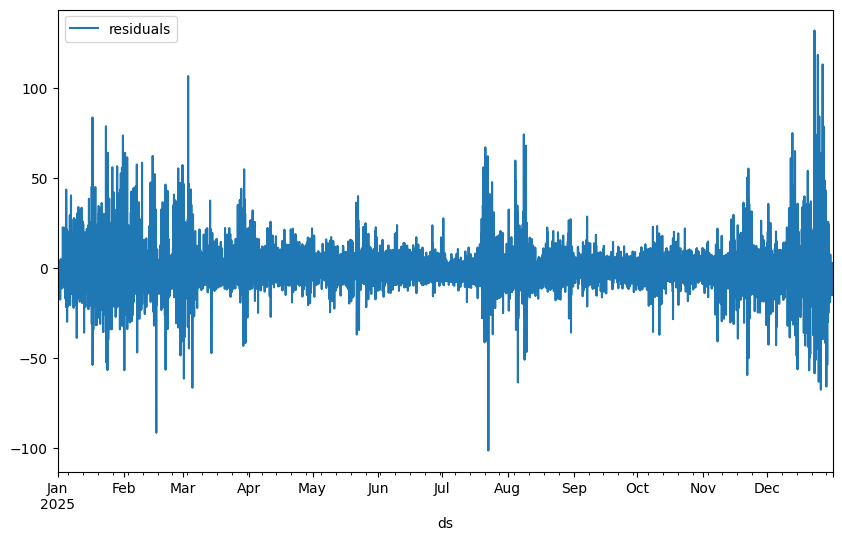

In [153]:
df_residuals = pd.DataFrame({"ds": result["ds"], "residuals": result["y"] - result["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

In [128]:
result

,ds,y,yhat1,ar1,trend,season_yearly,season_weekly,season_daily
0,2025-01-01 00:00:00,32.22,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-01-01 01:00:00,32.12,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-01-01 02:00:00,30.76,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-01-01 03:00:00,29.60,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-01-01 04:00:00,30.78,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8755,2025-12-31 19:00:00,38.88,37.081764,-130.124969,116.570511,44.469673,-7.018832,13.185376
8756,2025-12-31 20:00:00,38.68,35.883392,-120.441933,116.576508,44.654057,-7.034948,2.129719
8757,2025-12-31 21:00:00,38.65,39.715096,-109.759682,116.582504,44.833138,-7.014561,-4.926300
8758,2025-12-31 22:00:00,38.95,43.931873,-102.614235,116.588486,45.017590,-6.957335,-8.102635


In [152]:
m.plot_parameters(components=["autoregression"])

ERROR - (NP.plotly.plot_parameters) - plotly-resampler is not installed. Please install it to use the resampler.


In [140]:
for i in range(24*6):
    print((result[result['ds'].dt.hour == i]["yhat1"] - result[result['ds'].dt.hour == i]["y"]).abs().mean())

6.316586960383824
3.999691147018265
2.9419948031876113
2.769353446122054
5.232125145419614
8.925362418457702
8.90618812184791
8.159285052573845
8.20890976495612
8.131165355734629
8.11409176761157
5.485339861308059
5.294126754760742
4.68893126688918
6.3211360536340155
8.407975909507437
8.50950687021752
12.100545780129627
10.193390538045804
9.76103009994716
7.296041409427174
6.278803452792233
4.986283965646404
8.071850393007878
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [106]:
m.highlight_nth_step_ahead_of_each_forecast(1).plot(24*4.5)

ValueError: Provided DataFrame (df) must be of pd.DataFrame type.

In [ ]:

# Need to add n_lags steps to the beginning of the dataframe so the days can be used in the forecast
if lag_days > 1:

    jan_1 = df_prophet.iloc[0:24, :].copy()

    append_to_start = pd.DataFrame()

    for i in range(lag_days-1):
        temp = jan_1.copy()
        temp['ds'] = temp['ds'] - timedelta(days=(1+i))
        append_to_start = pd.concat([temp, append_to_start])

df_prophet = pd.concat([append_to_start, df_prophet])
df_prophet

# Now we will create a dataframe for each forecast day of the year

forecast = perfect_foresight_forecast["LMP"].copy()

for i, date in enumerate(forecast.index):
    temp_df = df_prophet.iloc[0:(i+lag_days+forecast_days)*24]
    day_forecast = m.get_latest_forecast(m.predict(temp_df))
    print(day_forecast)


In [ ]:
# for i, date in enumerate(forecast.index):

i = 0
temp_df = df_prophet.iloc[i*24:(i+lag_days+forecast_days+1)*24]
day_forecast = m.get_latest_forecast(temp_df)
print(day_forecast)

In [ ]:
x = m.get_latest_forecast(m.predict(df_prophet.iloc[0:24*31]))
x

In [ ]:
predictions = m.predict(df_prophet)

In [ ]:
m.plot_components(m.predict(df_prophet))

In [ ]:

forecast = m.predict(df_prophet)

In [ ]:
predictions.iloc[(31)*24:(31+1)*24 , :]

In [ ]:
m.get_latest_forecast(predictions)

## Compare Models

In [33]:
results = pd.DataFrame()

results["Mean Persistance"] = (mean_forecast["LMP"] - perfect_foresight_forecast["LMP"]).abs().mean()
results["Prophet no Regressors"] = (prophet_forecast_no_regressors - perfect_foresight_forecast["LMP"]).abs().mean()
results["Prophet with Regressors"] = (prophet_forecast_with_regressors - perfect_foresight_forecast["LMP"]).abs().mean()

px.line(results)

In [ ]:
m.plot_components(x)

## Prophet Model
New model each day

In [ ]:
from prophet import Prophet

# Delete this late
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

def create_prophet_forecast(df_ALEAF, perfect_foresight_forecast, n_days=7, to_excel_file=True):

    df_prophet = df_ALEAF[["Energy-DA"]].copy()
    forecast = initialize_empty_dataframe_for_forecast(df_ALEAF)
    forecast.iloc[:, 0:24] = perfect_foresight_forecast["LMP"].iloc[:, 0:24]


    for idx, date in enumerate(forecast.index):

        temp = df_prophet[(df_prophet.index <= date + timedelta(days=1) - timedelta(hours=1)) & (df_prophet.index > date - timedelta(days=n_days-1) - timedelta(hours=1))]

        floor = temp["Energy-DA"].groupby(temp.index.hour).quantile(.1).to_numpy() - 0.1
        cap = temp["Energy-DA"].groupby(temp.index.hour).quantile(.9).to_numpy() + 0.1

        temp = temp.reset_index()
        temp = temp.rename(columns={"Date-Time": "ds", "Energy-DA": "y"})

        temp["cap"] = np.tile(cap, 7)[0: len(temp.index)]
        temp["floor"] = np.tile(floor, 7)[0: len(temp.index)]

        m = Prophet(growth="logistic")
        m.fit(temp)

        future_times = m.make_future_dataframe(periods=24*6, freq="h")

        future_times["cap"] = np.tile(cap, 7+idx)[0: len(future_times.index)]
        future_times["floor"] = np.tile(floor, 7+idx)[0: len(future_times.index)]

        prophet_forecast = m.predict(future_times)

        forecast.iloc[idx, -6*24:] = prophet_forecast['yhat'].to_numpy()[-6*24:]

    forecast.index = forecast.index.astype(str)

    if to_excel_file:
        # Make sure there is a folder to write the results to 
        if os.path.exists(os.path.join(os.getcwd(), "Forecast_Generated")) == False:
            os.mkdir("Forecast_Generated")

        forecast.to_excel("Forecast_Generated/Prophet.xlsx", sheet_name="LMP")

    return forecast

prophet_forecast = create_prophet_forecast(df_ALEAF, perfect_foresight_forecast, n_days=7)
prophet_forecast.head()


## Neural-Prophet
single model for yearly data

In [ ]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")
df_prophet = df_ALEAF[["Energy-DA"]].copy()

# Set up prophet dataframe to train model
df_prophet = df_ALEAF[["Energy-DA"]].copy()
df_prophet = df_prophet.reset_index()
df_prophet = df_prophet.rename(columns={"Date-Time": "ds", "Energy-DA": "y"})


# Parameters for model
changepoints_range = 1 # Trend changepoint location over dataset
epochs = 20         # Number of steps
forecast_days = 2   # Number of days need to forecast
lag_days = 3        # Number of lags to use in forecast 

m = NeuralProphet(changepoints_range=changepoints_range,
                  epochs=epochs,            
                  n_forecasts=forecast_days*24,   
                  n_lags=lag_days*24,        
                  )

# Train the model
m.fit(df_prophet)

# Need to add n_lags steps to the beginning of the dataframe so the days can be forecasted
if lag_days > 1:

    jan_1 = df_prophet.iloc[0:24, :].copy()

    append_to_start = pd.DataFrame()

    for i in range(lag_days-1):
        temp = jan_1.copy()
        temp['ds'] = temp['ds'] - timedelta(days=(1+i))
        append_to_start = pd.concat([temp, append_to_start])

df_prophet = pd.concat([append_to_start, df_prophet])

In [ ]:
forecast = m.predict(df_prophet)
forecast

In [ ]:
future = m.make_future_dataframe(df_prophet)
future

In [ ]:
forecast = m.predict(df_prophet)
forecast

In [ ]:
m.get_latest_forecast(forecast, include_previous_forecasts=5)

In [ ]:
df_prophet

In [ ]:
np.append(np.array([0, 1, 2]), np.array([3, 4]))

In [ ]:
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

m = NeuralProphet(
    growth="off",
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3 * 24,
    n_forecasts=6*24,
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
)

In [ ]:
df_prophet = df_ALEAF[["Energy-DA"]].copy()

df_prophet = df_ALEAF[["Energy-DA"]].copy()
df_prophet = df_prophet.reset_index()
df_prophet = df_prophet.rename(columns={"Date-Time": "ds", "Energy-DA": "y"})

m.fit(df_prophet)

In [ ]:
forecast = m.predict(df_prophet)
forecast

In [ ]:
future = m.make_future_dataframe(df_prophet, periods=24*6)
future

In [ ]:
forecast = m.predict(future)
forecast

In [ ]:
forecast.iloc[-1, :]

In [ ]:
x = forecast.iloc[:, 2:].sum(axis=1)

In [ ]:
px.line(x)

In [ ]:
forecast = perfect_foresight_forecast["LMP"].copy()

for i, date in enumerate(forecast.index[8:]):
    dates = pd.DataFrame({'ds': pd.date_range(start=date, periods=24*6, freq="h")})
    dates["y"] = None
    temp = m.predict(dates)["yhat"]
    forecast.iloc[i, 24:] = temp.values

error = (forecast - perfect_foresight_forecast["LMP"])
px.line(error.abs().mean())


In [ ]:
fig = temp.plot(x="ds", y=["y", "origin-0"], figsize=(10, 6))

In [ ]:
df_residuals = pd.DataFrame({"ds": df_prophet["ds"], "residuals": df_prophet["y"] - forecast["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

In [ ]:
df_residuals

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"], lags=7*24)

In [ ]:
m = NeuralProphet(changepoints_range=1, # Allow changepoints at any part of data
                  season
                )
m.fit(df_prophet)

# forecast = m.predict(df_prophet)
# m.plot(forecast)

In [ ]:
forecast = m.predict(df_prophet)
m.plot(forecast)

In [ ]:
m.make_future_dataframe(df_prophet, periods=24*7)

In [ ]:
test_df = pd.DataFrame({'ds': pd.date_range(start='2025-6-1', periods=24*7, freq='h')})
test_df["y"] = None

forecast = m.predict(test_df)
forecast

In [ ]:
test_df = pd.DataFrame({'ds': pd.date_range(start='2025-6-1', periods=24*7, freq='h')})

In [ ]:
m.plot(forecast)
# fig_components = m.plot_components(forecast)
# fig_model = m.plot_parameters()

In [ ]:
m.plot_components(forecast)

In [ ]:
m.plot_parameters()

## PyTorch LSTM Neural Network

In [ ]:
import torch
import torch.nn as nn




In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)


## Ax=B

In [ ]:
df = df_ALEAF[["Energy-DA"]].copy()

forecast = initialize_empty_dataframe_for_forecast(df_ALEAF)
forecast.iloc[:, 0:24] = perfect_foresight_forecast["LMP"].iloc[:, 0:24]


# Create dataframe needed columns to construct A and b
for hour in range(0, 24):
    df.loc[:, f"hour {hour}"] = 0
    df.loc[df.index.hour == hour, f"hour {hour}"] = 1

for day in df.index.day_name().unique():
    df.loc[:, day] = 0
    df.loc[df.index.day_name() == day, day] = 1


date = forecast.index[14]

n_days = 14

for date in forecast.index:

    # Use this data to get A and b then solve for x
    temp = df.loc[(df.index < date + timedelta(days=1)) & (df.index > date - timedelta(days=n_days-1) - timedelta(hours=1))]
    A = temp.iloc[:, 1:]
    b = temp.iloc[:, 0]

    x = np.linalg.lstsq(A, b)[0]


    # Now extract A from the future days and solve for b 
    A_forecast = df.loc[(df.index > date + timedelta(hours=23)) & (df.index < date + timedelta(days=7))]

    b_forecast = (A_forecast.iloc[:, 1:].to_numpy() * x)

    week_forecast = sum(b_forecast.T)

    print(date)
    print(week_forecast)




In [ ]:
week_forecast

In [ ]:

# # Each day we reconstruct A and b 
# for idx, date in enumerate(forecast.index[14:15]):
    
#     temp = df.loc[(df.index <= date + timedelta(days=1) - timedelta(hours=1)) & (df.index > date - timedelta(days=n_days-1) - timedelta(hours=1))]

#     # print(temp)

#     A = temp.iloc[:, 1:]
#     b = temp.iloc[:, 0]

#     x = np.linalg.lstsq(A, b)[0]

#     A_next_6_days = df.loc[(df.index > date + timedelta(days=1) - timedelta(hours=1)) & (df.index < date + timedelta(days=6))]
#     A_next_6_days = A_next_6_days.iloc[:, 1:]
    
#     print(sum((A_next_6_days.to_numpy() * x).T))

#     forecast()


    # print(df.loc[(df.index <= date) & (df.index >= date - timedelta(days=7)),])

    # A = df.loc[(df.index <= date) & (df.index >= date - timedelta(days=7)),]
    # b = df.loc[(df.index <= date) & (df.index >= date - timedelta(days=7)), "Energy-DA"]
        
    # x = x = np.linalg.lstsq(A, b)[0]


    # def get_forecast(forecast_df):

        # for idx, date in enumerate(forecast_df.index):
        #     print(date)
        #     # # Use the previous days mean to forecast days 2-7, with day-ahead being correct values
        #     # if idx == 0:
        #     #     hour_means = forecast_df.iloc[0, 0:24].to_numpy()
        #     # elif idx < n_days:
        #     #     hour_means = forecast_df.iloc[0:idx, 0:24].mean().to_numpy()
        #     # else:
        #     #     hour_means = forecast_df.iloc[idx-n_days:idx, 0:24].mean().to_numpy()

        #     # hour_means = np.tile(hour_means, 6)

        #     # forecast_df.iloc[idx, 24:] = hour_means

        # return forecast_df
    

    
    
    # LMP_forecast = get_forecast(perfect_foresight_forecast["LMP"].copy())
    # Reg_up_forecast = get_forecast(perfect_foresight_forecast["Regulation Up"].copy())
    # Reg_down_forecast = get_forecast(perfect_foresight_forecast["Regulation Down"].copy())
    # Spin_forecast = get_forecast(perfect_foresight_forecast["Spin"].copy())
    
    # if to_excel_file:
    #     # Make sure there is a folder to write the results to 
    #     if os.path.exists(os.path.join(os.getcwd(), "Forecast_Generated")) == False:
    #         os.mkdir("Forecast_Generated")

    #     # Lets drop the timestamp from the column names M-d-Y H:mm:ss --> M-d-Y 
    #     dates_to_string = LMP_forecast.index.astype(str)

    #     LMP_forecast.index = dates_to_string
    #     Reg_up_forecast.index = dates_to_string
    #     Reg_down_forecast.index = dates_to_string
    #     Spin_forecast.index = dates_to_string

    #     with pd.ExcelWriter("Forecast_Generated/Mean_Persistence_Forecast.xlsx") as writer:
    #         LMP_forecast.T.to_excel(writer, sheet_name="LMP")
    #         Reg_up_forecast.T.to_excel(writer, sheet_name="Reg Up")
    #         Reg_down_forecast.T.to_excel(writer, sheet_name="Reg Down")
    #         Spin_forecast.T.to_excel(writer, sheet_name="Spin")

    # return {"LMP": LMP_forecast, 
    #         "Regulation Up": Reg_up_forecast, 
    #         "Regulation Down": Reg_down_forecast,
    #         "Spin": Spin_forecast,}


# Ax_b_forecast = create_Ax_b_forecast(df_ALEAF, perfect_foresight_forecast, 7, False)
# Ax_b_forecast

In [ ]:
df = df_ALEAF[["Energy-DA"]]

for hour in range(0, 24):
    df[f"{hour}"] = 0
    df.loc[df.index.hour == hour, f"{hour}"] = 1

df

In [ ]:
A = df.iloc[:, 1:].to_numpy()
b = df.iloc[:, 0].to_numpy()

x = np.linalg.lstsq(A, b)
x

In [ ]:
x[0]

In [ ]:
test = sum((A * x[0]).T)
test

In [ ]:
df["test"] = sum((A * x[0]).T)

In [ ]:
px.line(df[["Energy-DA", "test"]])